In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from lenspack.image.inversion import ks93, ks93inv
from lenspack.halo.profiles import nfw_profile
from astropy.io import fits
from astropy import units as u
import numpy as np
import jax

In [3]:
z_halo = 0.5
mass_halo = 1e14

In [4]:
"""Navarro, Frenk, & White (1997) radial halo density profile.
        rho(r; rho0, rs) = rho0 / [(r / rs) * (1 + r / rs)^2],
        where rho0 can be written as the product delta_c * rho_crit. The more
        common (and useful) parameterization is (c200, m200) instead of
        (rho0, rs).
        
Parameters
        ----------
        z : float
            Halo redshift. [dimensionless]
        c200 : float
            Halo concentration. [dimensionless]
        m200 : float, optional
            Spherical mass contained within a radius `r200`. [solar mass]
        r200 : float, optional
            Characteristic halo radius. [Mpc]
        cosmology : {'default', instance of `astropy.cosmology`}
            Cosmological model in which to calculate distances. The default
            is a `FlatLambdaCDM` object with parameters H0=70, Om0=0.3,
            Ob0=0.044, and Tcmb0=2.725. Alternatively, a custom cosmology can
            be provided as an instance of `astropy.cosmology`.
"""
halo = nfw_profile(z=z_halo, c200=1, m200=mass_halo, r200=None, cosmology='default')

In [5]:
"""Tangential shear magnitude experienced by a source object.
        Parameters
        ----------
        r : float or array_like
            Projected radial (proper) distance from the source to the halo
            center. Units of Mpc are assumed if `r` is not given an astropy
            quantity.
        zs : float or array_like
            Redshift of the source. If a single float is given, this value is
            used for each `r`.
        r_off : float, optional
            Projected radial offset of the halo center.
"""

gamma_t = halo.gamma_t(r=10, zs=1)

In [6]:
gamma_t

0.0008064550883302336

In [7]:
resolution = 0.29*u.arcmin #arcmin/pixel
cosmo = halo.cosmo
d_A = cosmo.angular_diameter_distance(z=z_halo)
distance_Mpc = (resolution * d_A).to(u.Mpc, u.dimensionless_angles()) # Mpc/pixel

In [8]:
#resolution = 0.29*u.arcmin #arcmin/pixel
#distance_Mpc = (resolution * d_A).to(u.Mpc, u.dimensionless_angles()) # Mpc/pixel
#distance_Mpc

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


nan


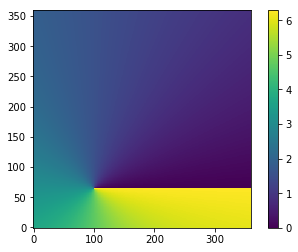

In [9]:
nx = 360# map width pixel
ny = 360 # map height pixel
x = 65 # cluster x coord pixel
y = 100 # cluster y coord pixel

dist_from_halo = np.zeros((nx, ny)) 
phi_halo = np.zeros((nx, ny))

for i in range(ny):
    for j in range(nx):
        dist_from_halo[i,j] = np.sqrt((i-x)**2 + (j-y)**2)
        #phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])

for i in range(ny):
    for j in range(nx):
        if i-x > 0:
            phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])
        else:
            phi_halo[i,j] = 2*np.pi - np.arccos((j-y) / dist_from_halo[i,j])

dist_from_halo = dist_from_halo * distance_Mpc
            
print(phi_halo[x, y])
phi_halo[x, y] = 0.
imshow(phi_halo, origin="bottom")
#imshow(dist_from_halo)
colorbar()

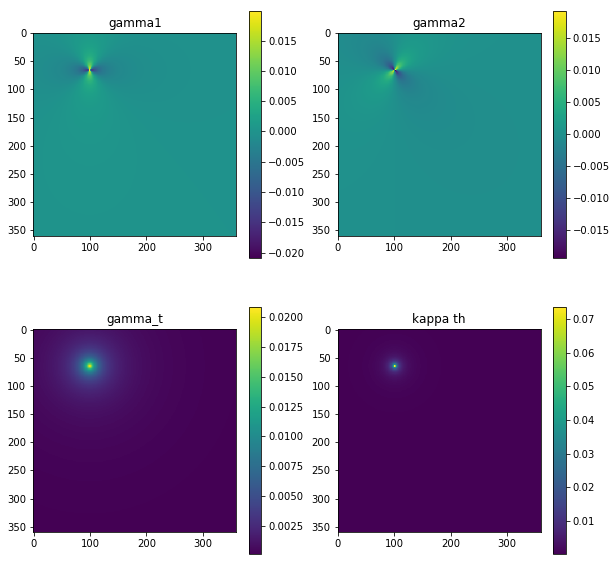

In [10]:
gamma_t = halo.gamma_t(r=dist_from_halo, zs=1)

kappa_th = halo.kappa(r=dist_from_halo, zs=1)

gamma_1 = -gamma_t * np.cos(2*phi_halo)
gamma_2 = -gamma_t * np.sin(2*phi_halo)

figure(figsize=(10,10))
subplot(221)
title('gamma1')
imshow(gamma_1)
colorbar()

subplot(222)
title('gamma2')
imshow(gamma_2)
colorbar()

subplot(223)
title('gamma_t')
imshow(gamma_t)
colorbar()

subplot(224)
title('kappa th')
imshow(kappa_th)
colorbar()

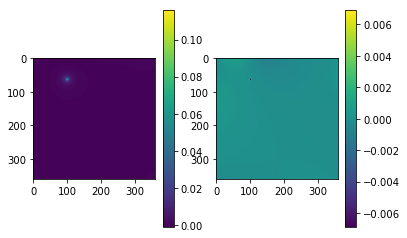

In [11]:
ke, kb = ks93(gamma_1, gamma_2)
subplot(121)
imshow(ke)
colorbar()
subplot(122)
imshow(kb)
colorbar()

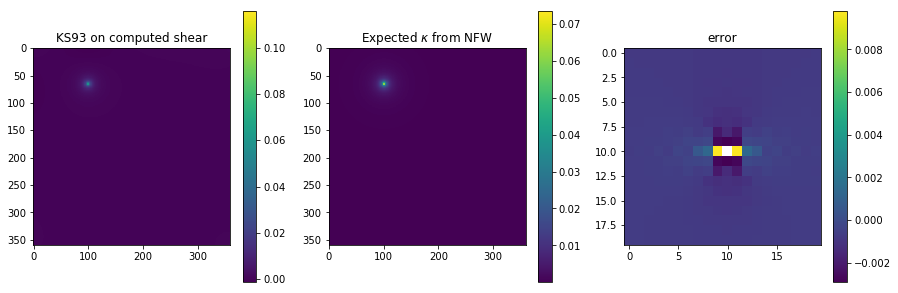

In [12]:
k = np.sqrt(ke**2+kb**2)

figure(figsize=(15,5))
subplot(131)
title('KS93 on computed shear')
imshow(ke)
colorbar()
subplot(132)
title(r'Expected $\kappa$ from NFW')
imshow(kappa_th)
colorbar()

subplot(133)
title('error')
error = ke - kappa_th
imshow(error[x-10:x+10, y-10:y+10])
colorbar()

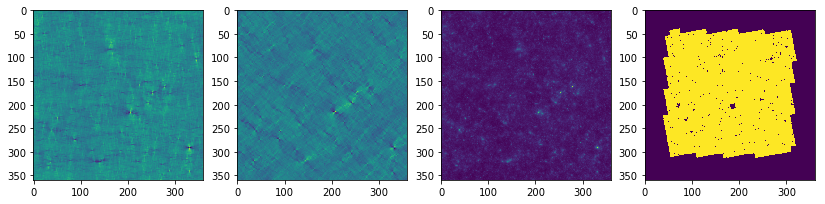

In [13]:
meas_shear = fits.getdata('../data/ktng/ktng_cosmos_e360.fits').astype('float32')
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

meas_shear = np.stack(ks93inv(convergence, np.zeros_like(convergence)), axis=-1)

mask = np.expand_dims(mask, -1)
masked_true_shear = meas_shear #* mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(masked_true_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [14]:
def gen_nfw_shear(x_cen, y_cen, resolution, nx, ny, z, m, zs=None, redshift_distribution=None, como=None):
    """
    returns: a map g1,g2 of size [nx,ny]
    """

    halo = nfw_profile(z=z, c200=1, m200=m, r200=None, cosmology='default')

    resolution = resolution*u.arcmin #arcmin/pixel
    cosmo = halo.cosmo
    d_A = cosmo.angular_diameter_distance(z=z_halo)
    distance_Mpc = (resolution * d_A).to(u.Mpc, u.dimensionless_angles()) # Mpc/pixel

    dist_from_halo = np.zeros((nx, ny)) 
    phi_halo = np.zeros((nx, ny))

    for i in range(ny):
        for j in range(nx):
            dist_from_halo[i,j] = np.sqrt((i-x)**2 + (j-y)**2)
            #phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])

    for i in range(ny):
        for j in range(nx):
            if i-x > 0:
                phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])
            else:
                phi_halo[i,j] = 2*np.pi - np.arccos((j-y) / dist_from_halo[i,j])

    dist_from_halo = dist_from_halo * distance_Mpc
    phi_halo[x, y] = 0.
    
    gamma_t = halo.gamma_t(r=dist_from_halo, zs=zs)

    gamma_1 = - gamma_t * np.cos(2*phi_halo)
    gamma_2 = - gamma_t * np.sin(2*phi_halo)
    
    return gamma_1, gamma_2

In [15]:
resolution = 0.29 #arcmin/pixel
z_halo = 0.5
mass_halo = 3e14
zs = 1

nx = 360# map width pixel
ny = 360 # map height pixel
x = 100 # cluster x coord pixel
y = 200 # cluster y coord pixel

g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=mass_halo, zs=zs)

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


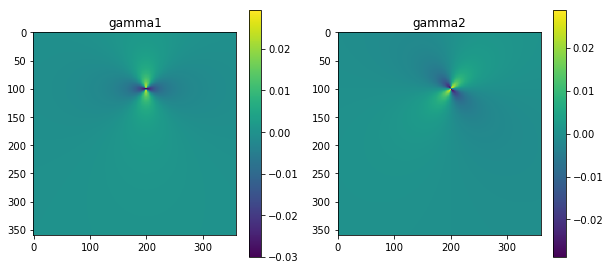

In [16]:
figure(figsize=(10,10))
subplot(221)
title('gamma1')
imshow(g1)
colorbar()

subplot(222)
title('gamma2')
imshow(g2)
colorbar()

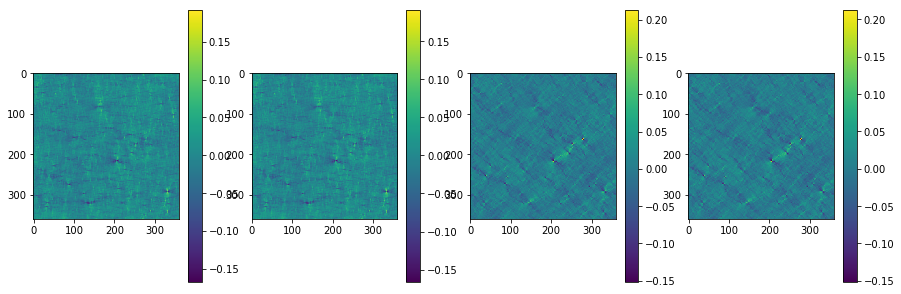

In [17]:
figure(figsize=(15,5))
subplot(141)
imshow(meas_shear[...,0])
colorbar()
subplot(142)
imshow(meas_shear[...,0] + g1)
colorbar()
subplot(143)
imshow(meas_shear[...,1])
colorbar()
subplot(144)
imshow(meas_shear[...,1] + g2)
colorbar()

In [18]:
resolution = 0.29 #arcmin/pixel
z_halo = 0.5
mass_halo = 3e14
zs = 1

nx = 360# map width pixel
ny = 360 # map height pixel
x = 65 # cluster x coord pixel
y = 130 # cluster y coord pixel

g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=mass_halo, zs=zs)
ke_cluster, kb_cluster = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,1,'$\\kappa$ map with cluster (zoom)')

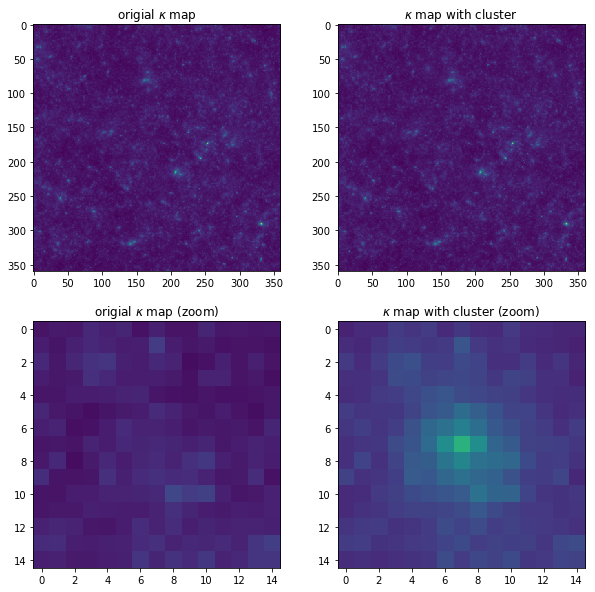

In [19]:
w = 7
figure(figsize(10,10))
subplot(221)
#imshow(convergence[100-w:100+w, 100-w:100+w])
imshow(convergence)
title(r'origial $\kappa$ map')
subplot(222)
#imshow(ke_cluster[100-w:100+w, 100-w:100+w])
imshow(ke_cluster)
title(r'$\kappa$ map with cluster')

vmin = -0.05
vmax = 0.3
subplot(223)
imshow(convergence[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
title(r'origial $\kappa$ map (zoom)')
subplot(224)
imshow(ke_cluster[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
title(r'$\kappa$ map with cluster (zoom)')

In [20]:
g1_cluster, g2_cluster = ks93inv(ke_cluster, np.zeros_like(ke_cluster))

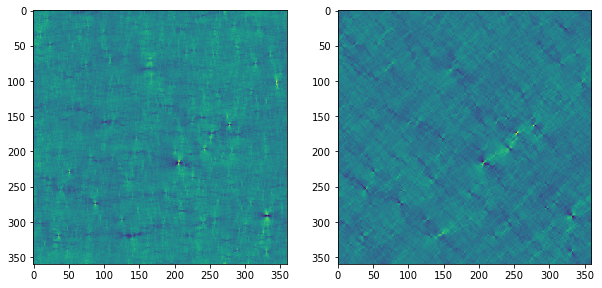

In [21]:
subplot(121)
imshow(g1_cluster)
subplot(122)
imshow(g2_cluster)

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import numpy as np
from astropy.io import fits
#s = fits.getdata('/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/samples_1.fits')

In [24]:
#s.shape

In [25]:
#imshow(s[-1,0,:].reshape(360,360),cmap='magma')
w = 10
vmin = -0.05
vmax = 0.3

Cluster sample at $\sigma = 0.148$

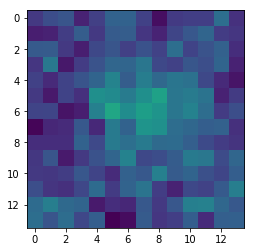

In [26]:
filename = '/gpfswork/rech/xdy/commun/nfw_samples/65_130_.5_3e14_1/old/samples_0.148_'
samples148 = fits.getdata(filename+'1.fits')

for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples148 = np.concatenate([samples148, s], axis=1)
    
w = 7
x=65
y=130
imshow(samples148[-1,6,:].reshape(360,360)[x-w:x+w, y-w:y+w], vmin=vmin, vmax=vmax)

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


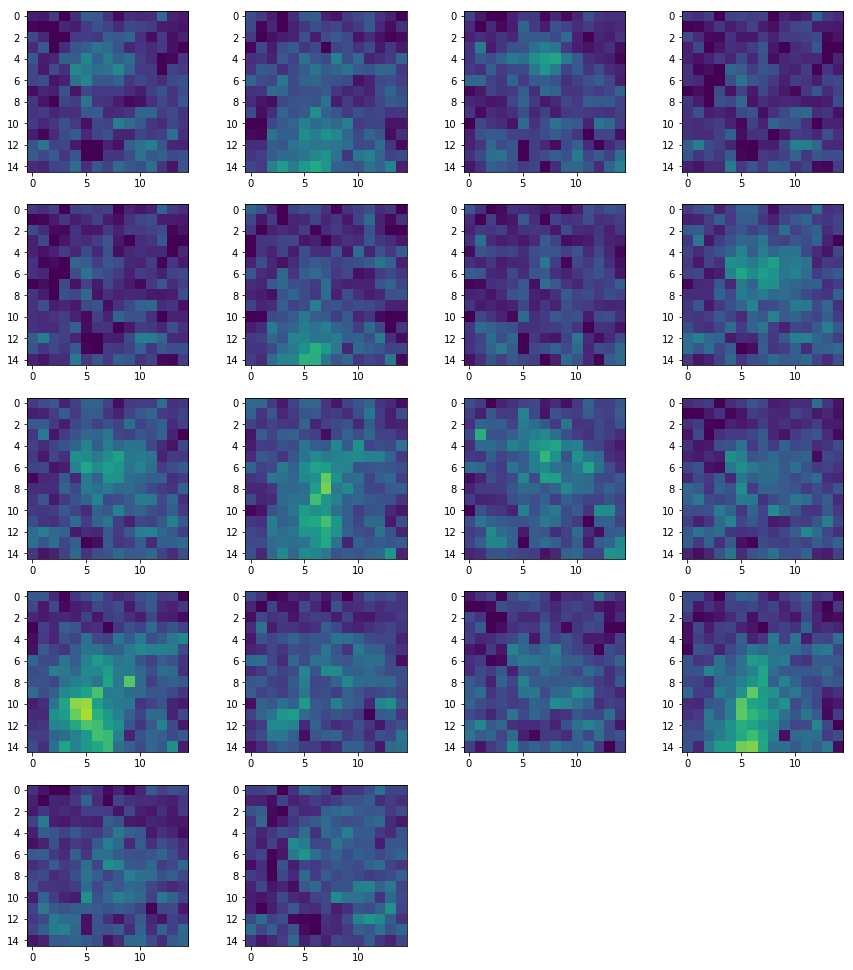

In [27]:
figure(figsize(15,35))
for i in range(3):
    for j in range(10):
        subplot(10,4,4*i+j+1)
        #imshow(samples148[-1,3*i+j,:].reshape(360,360))
        imshow(samples148[-1,3*i+j,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)

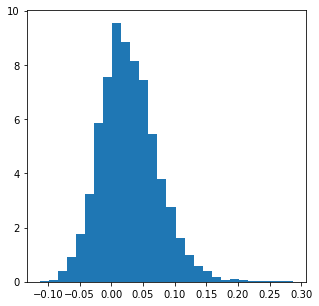

In [28]:
s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w, y-w:y+w]

figure(figsize=(5,5))
plt.hist(s148.flatten(),bins=28, density=True);

Cluster sample at $\sigma = 0.07$

In [29]:
filename = '/gpfswork/rech/xdy/commun/nfw_samples/65_130_.5_3e14_1/old/samples_0.07_'
samples07 = fits.getdata(filename+'1.fits')
for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples07 = np.concatenate([samples07, s], axis=1)

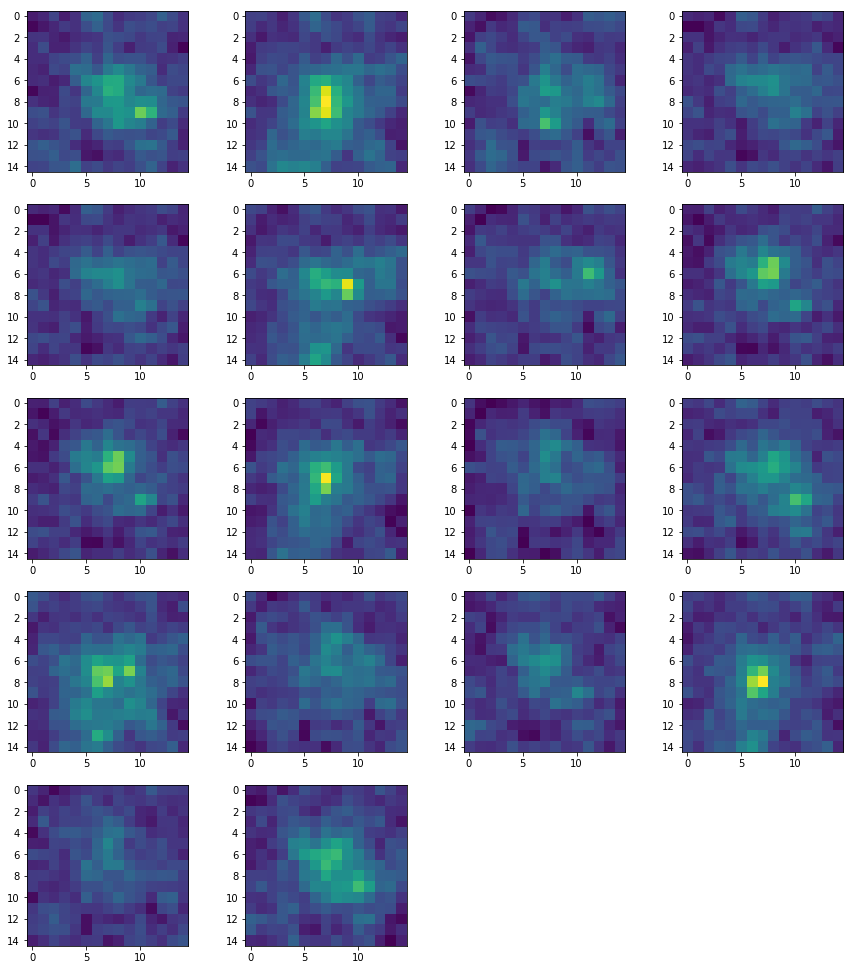

In [30]:
figure(figsize(15,35))
for i in range(3):
    for j in range(10):
        subplot(10,4,4*i+j+1)
        #imshow(samples07[-1,3*i+j,:].reshape(360,360))
        imshow(samples07[-1,3*i+j,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
        #colorbar()

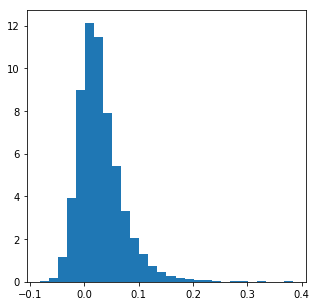

In [31]:
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]

figure(figsize=(5,5))
plt.hist(s07.flatten(),bins=28, density=True);

Cluster sample at $\sigma = 0.21$

In [32]:
filename = '/gpfswork/rech/xdy/commun/nfw_samples/65_130_.5_3e14_1/old/samples_0.21_'
samples21 = fits.getdata(filename+'1.fits')
for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples21 = np.concatenate([samples21, s], axis=1)

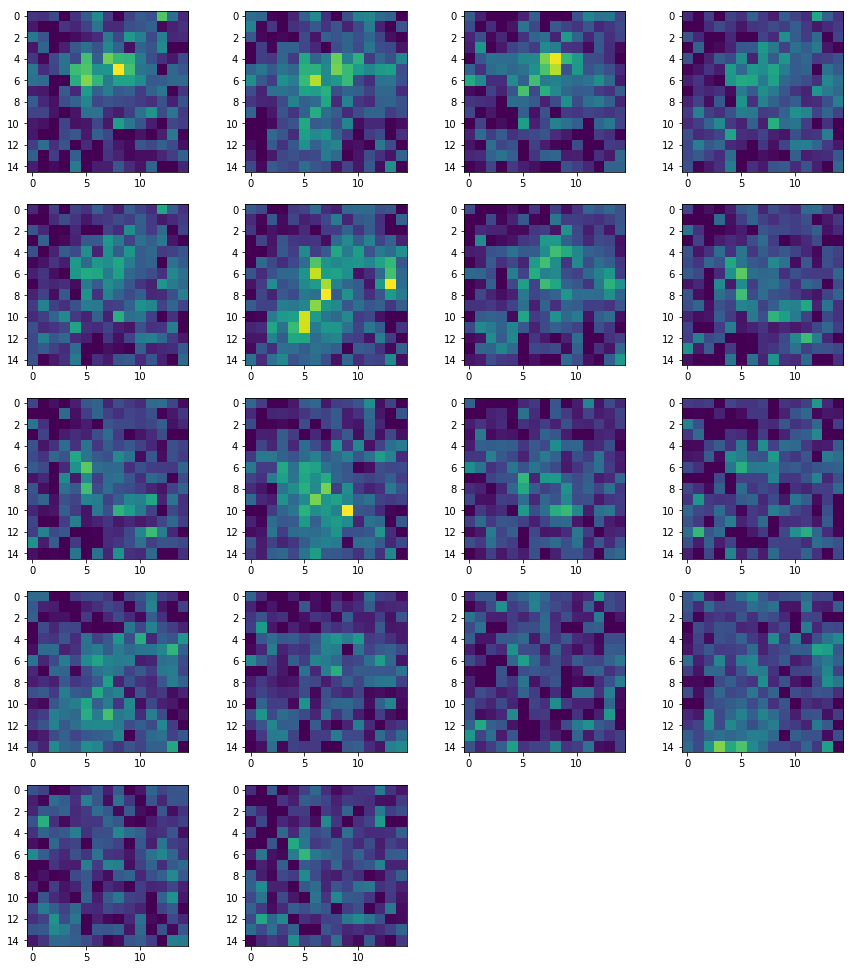

In [33]:
figure(figsize(15,35))
for i in range(3):
    for j in range(10):
        subplot(10,4,4*i+j+1)
        #imshow(samples21[-1,3*i+j,:].reshape(360,360))
        #w = 2
        imshow(samples21[-1,3*i+j,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
        #colorbar()

<Figure size 360x360 with 0 Axes>

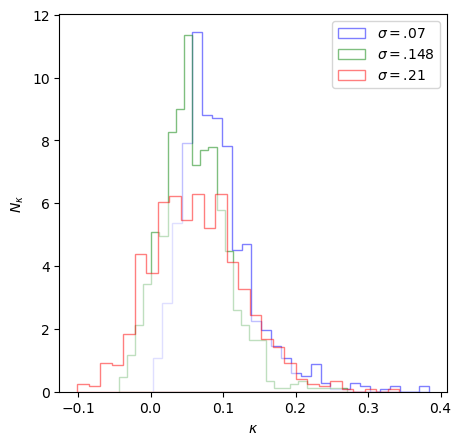

In [34]:
w = 2

s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s21 = samples21[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]

figure(figsize=(5,5))

kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=28, color='white')

figure(figsize=(5,5),dpi=100)
plt.hist(s07.flatten(), label=r'$\sigma=$.07', ec="blue", **kwargs);
plt.hist(s148.flatten(), label=r'$\sigma=$.148', ec="green", **kwargs);
plt.hist(s21.flatten(), label=r'$\sigma=$.21', ec="red", **kwargs);
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()

Histogram of stamps intensity summaries

<Figure size 360x360 with 0 Axes>

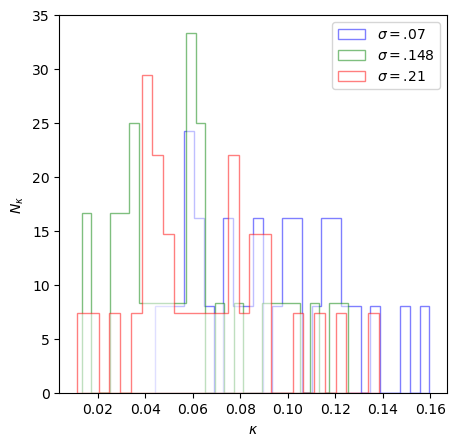

In [35]:
w = 2

s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s148 = np.mean(s148, axis=(1,2))
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s07 = np.mean(s07, axis=(1,2))
s21 = samples21[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s21 = np.mean(s21, axis=(1,2))

figure(figsize=(5,5))

kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=28, color='white')

figure(figsize=(5,5),dpi=100)
plt.hist(s07.flatten(), label=r'$\sigma=$.07', ec="blue", **kwargs);
plt.hist(s148.flatten(), label=r'$\sigma=$.148', ec="green", **kwargs);
plt.hist(s21.flatten(), label=r'$\sigma=$.21', ec="red", **kwargs);
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()

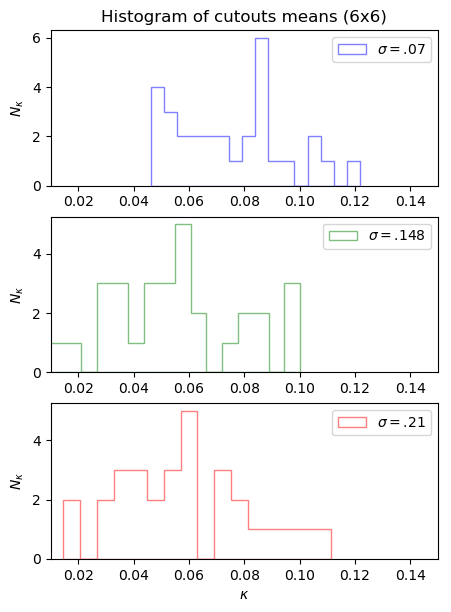

In [36]:
w = 3

s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s148 = np.mean(s148, axis=(1,2))
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s07 = np.mean(s07, axis=(1,2))
s21 = samples21[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s21 = np.mean(s21, axis=(1,2))

figure(figsize=(5,7),dpi=100)

kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, bins=16, color='white')

subplot(311)
title('Histogram of cutouts means (6x6)')
plt.hist(s07.flatten(), label=r'$\sigma=$.07', ec="blue", **kwargs);
xlim([.01, .15])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(312)
plt.hist(s148.flatten(), label=r'$\sigma=$.148', ec="green", **kwargs);
xlim([.01, .15])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(313)
plt.hist(s21.flatten(), label=r'$\sigma=$.21', ec="red", **kwargs);
xlim([.01, .15])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()

Stamp of the true cluster profile

0.07808511630514518


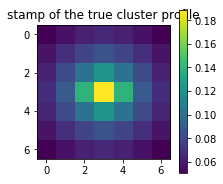

In [37]:
ke, kb = ks93(g1,g2)
figure(figsize(3,3))
imshow(ke[x-w:x+w+1, y-w:y+w+1])
colorbar()
title('stamp of the true cluster profile')

ke_stamp = np.repeat(ke[x-w:x+w+1, y-w:y+w+1].reshape(-1,2*w+1,2*w+1), 30, axis=0)
ke_mean = np.mean(ke_stamp)
print(np.mean(ke_stamp))

Histogram of stamps intensity summaries (**weight average**)

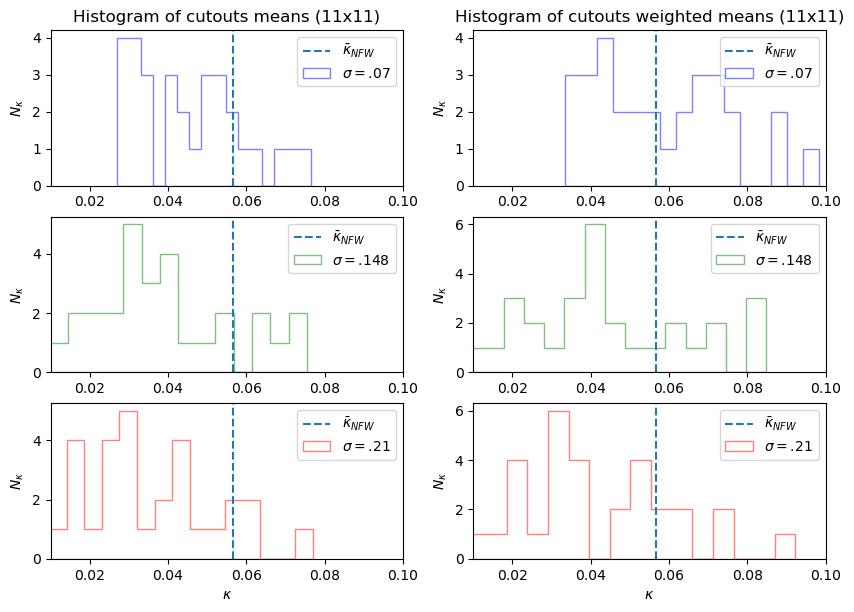

In [38]:
w = 5
x_max = 0.1

ke, kb = ks93(g1,g2)
ke_stamp = np.repeat(ke[x-w:x+w+1, y-w:y+w+1].reshape(-1,2*w+1,2*w+1), 30, axis=0)
ke_mean = np.mean(ke_stamp)

s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s148 = np.mean(s148, axis=(1,2))
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s07 = np.mean(s07, axis=(1,2))
s21 = samples21[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s21 = np.mean(s21, axis=(1,2))

figure(figsize=(10,7),dpi=100)

kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, bins=16, color='white')

subplot(321)
title('Histogram of cutouts means ({}x{})'.format(2*w+1,2*w+1))
plt.hist(s07.flatten(), label=r'$\sigma=$.07', ec="blue", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(323)
plt.hist(s148.flatten(), label=r'$\sigma=$.148', ec="green", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(325)
plt.hist(s21.flatten(), label=r'$\sigma=$.21', ec="red", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()

# With weighted average
s07 = samples07[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s07 = np.mean(s07*ke_stamp/ke_mean, axis=(1,2))
s148 = samples148[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s148 = np.mean(s148*ke_stamp/ke_mean, axis=(1,2))
s21 = samples21[-1,...].reshape(-1,360,360)[:,x-w:x+w+1, y-w:y+w+1]
s21 = np.mean(s21*ke_stamp/ke_mean, axis=(1,2))

subplot(322)
title('Histogram of cutouts weighted means ({}x{})'.format(2*w+1,2*w+1))
plt.hist(s07.flatten(), label=r'$\sigma=$.07', ec="blue", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(324)
plt.hist(s148.flatten(), label=r'$\sigma=$.148', ec="green", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()
subplot(326)
plt.hist(s21.flatten(), label=r'$\sigma=$.21', ec="red", **kwargs);
axvline(ke_mean, linestyle='--', label=r'$\bar{\kappa}_{NFW}$')
xlim([.01, x_max])
xlabel(r'$\kappa$')
ylabel(r'$N_\kappa$')
legend()

## Background

Samling with no cluster

In [39]:
filename = '/gpfswork/rech/xdy/commun/nfw_samples/background/samples_no_cluster_0.07_'
samples07_no = fits.getdata(filename+'1.fits')
for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples07_no = np.concatenate([samples07_no, s], axis=1)
    
filename = '/gpfswork/rech/xdy/commun/nfw_samples/background/samples_no_cluster_0.148_'
samples148_no = fits.getdata(filename+'1.fits')

for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples148_no = np.concatenate([samples148_no, s], axis=1)

filename = '/gpfswork/rech/xdy/commun/nfw_samples/background/samples_no_cluster_0.21_'
samples21_no = fits.getdata(filename+'1.fits')
for i in range(2,11):
    s = fits.getdata(filename+str(i)+'.fits')
    samples21_no = np.concatenate([samples21_no, s], axis=1)

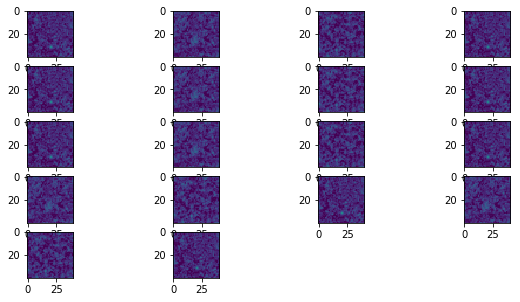

In [40]:
w = 20

figure(figsize(10,10))
for i in range(3):
    for j in range(10):
        subplot(10,4,4*i+j+1)
        #imshow(samples21[-1,3*i+j,:].reshape(360,360))
        #w = 2
        imshow(samples148_no[-1,3*i+j,:].reshape(360,360)[x-w:x+w, y-w:y+w], vmin=vmin, vmax=vmax)
        #colorbar()

## NFW profile as filter

0.015145430435123317


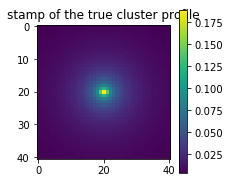

In [41]:
ke, kb = ks93(g1,g2)
figure(figsize(3,3))
imshow(ke[x-w:x+w+1, y-w:y+w+1])
colorbar()
title('stamp of the true cluster profile')

ke_stamp = np.repeat(ke[x-w:x+w+1, y-w:y+w+1].reshape(-1,2*w+1,2*w+1), 30, axis=0)
ke_mean = np.mean(ke_stamp)
print(np.mean(ke_stamp))

In [42]:
from jax.scipy import signal

def conv(img, filter_):
    return signal.convolve2d(img, filter_, mode='same')
    
conv = jax.vmap(conv)

In [43]:
w = 7

img = samples148_no[-1,:,:].reshape(-1,360,360)
filter_ = ke_stamp

print(img.shape)
print(filter_.shape)

convolutions = conv(img, filter_)

(30, 360, 360)
(30, 41, 41)


/linkhome/rech/genpuc01/utb76xl/.local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [44]:
convolutions.shape

(30, 360, 360)

(30, 360, 360)
(30, 41, 41)


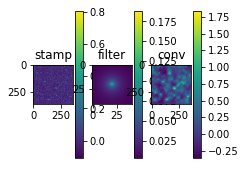

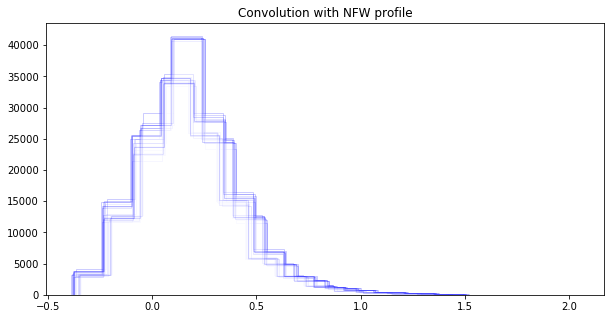

In [45]:
from scipy import signal
w = 7

#img = samples148_no[-1,0,:].reshape(360,360)
#filter_ = ke_stamp[0,...]

print(img.shape)
print(filter_.shape)
#conv = signal.convolve2d(img, filter_)

figure()
subplot(131)
title('stamp')
imshow(img[0,...])
colorbar()

subplot(132)
title('filter')
imshow(filter_[0,...])
colorbar()

subplot(133)
title('conv')
imshow(convolutions[0,...])
colorbar()

figure(figsize=(10,5))
for c in convolutions:
    kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=16, color='white')
    title('Convolution with NFW profile')
    plt.hist(c.flatten(), ec='blue', label=r'$\sigma=$.07', **kwargs);

## Starlet filter

In [46]:
filter_ = ke_stamp

In [47]:
from lenspack.image.transforms import starlet2d

#starlet2d = jax.vmap(starlet2d)

(6, 360, 360)


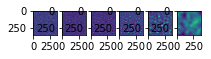

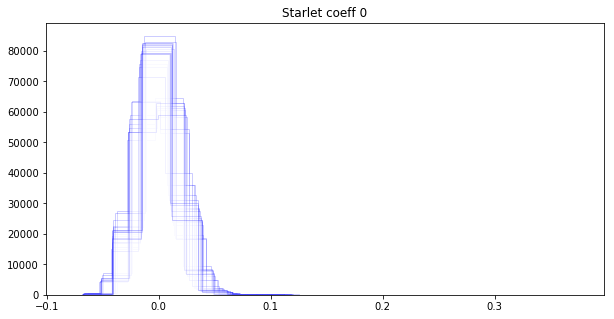

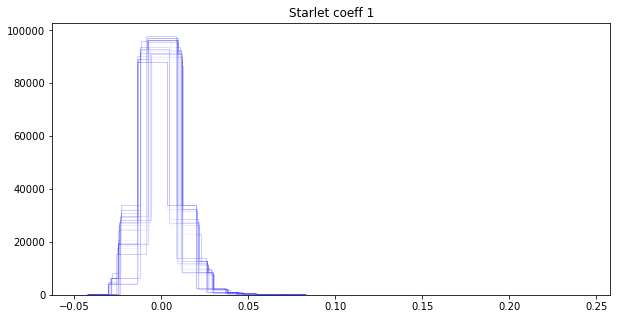

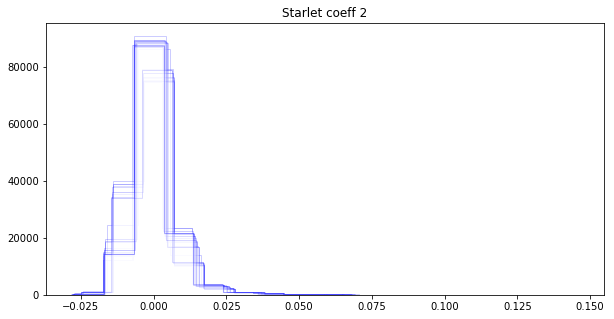

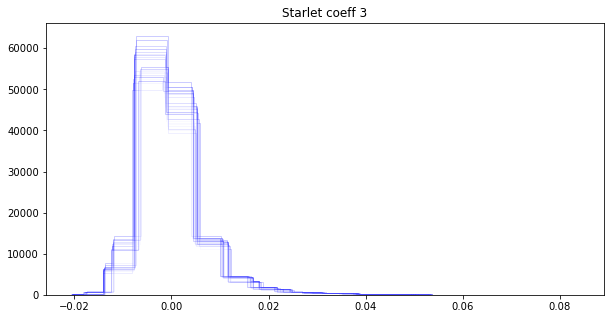

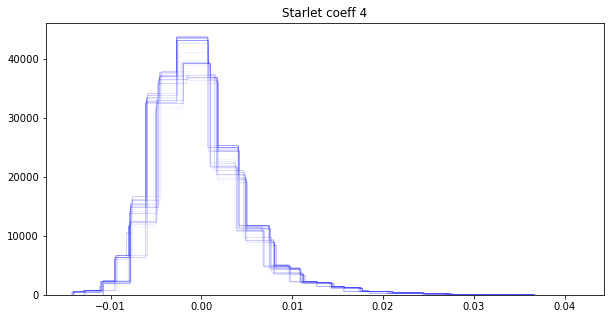

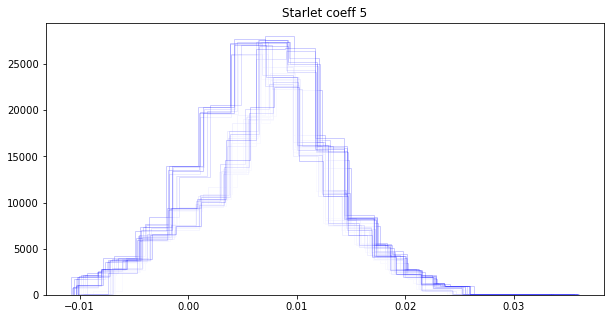

In [48]:
starlet_decomp = starlet2d(image=img[0,...], nscales=5)
print(starlet_decomp.shape)
figure(0)
for i in range(len(starlet_decomp)):
    subplot(1, len(starlet_decomp), i+1)
    imshow(starlet_decomp[i])

for k in range(len(img)):
    starlet_decomp = starlet2d(image=img[k,...], nscales=5)
    for i in range(len(starlet_decomp)):
        figure(i+1, figsize(10,5))
        #subplot(1, len(starlet_decomp), i+1)
        title('Starlet coeff {}'.format(i))
        kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=16, color='white')
        plt.hist(starlet_decomp[i].flatten(), ec='blue',  label=r'$\sigma=$.07', **kwargs);

## Detection
Look at the pick in cluster postage stamp

In [49]:
filename = '/gpfswork/rech/xdy/commun/nfw_samples/65_130_.5_3e14_1/0.148/samples_0.148_'
samples148 = fits.getdata(filename+'1.fits')

for i in range(2,41):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples148 = np.concatenate([samples148, s], axis=1)

print(samples148.shape)

(3, 324, 129600)


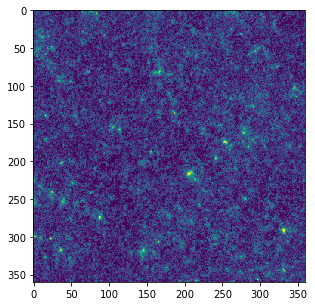

In [50]:
imshow(samples148[-1,10,...].reshape(360,360), vmin=vmin, vmax=vmax)

In [51]:
img = samples148[-1,...].reshape(-1,360,360)

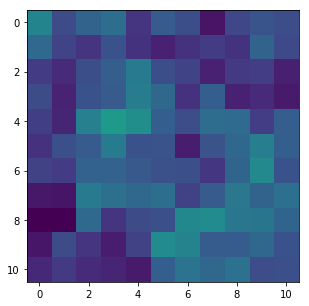

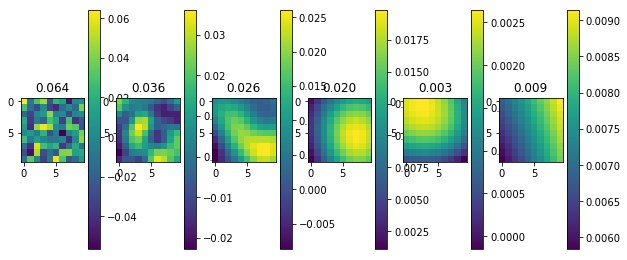

In [52]:
x=65
y=130
figure(0)

w = 5
ind = 0

imshow(img[ind,:][x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)


starlet_decomp = starlet2d(image=img[ind,...], nscales=5)
figure(1)
for i in range(len(starlet_decomp)):
    subplot(1, len(starlet_decomp), i+1)
    stamp = starlet_decomp[i][x-w:x+w, y-w:y+w]
    imshow(stamp)
    title('{:.3f}'.format(np.max(stamp)))
    colorbar()

In [53]:
from jax.scipy import signal

def conv(img, filter_):
    return signal.convolve2d(img, filter_, mode='same')
    
conv = jax.vmap(conv)

print(img.shape)
print(filter_.shape)
filter_ = np.repeat(ke[x-w:x+w+1, y-w:y+w+1].reshape(-1,2*w+1,2*w+1), img.shape[0], axis=0)
convolutions = conv(img, filter_)

(324, 360, 360)
(30, 41, 41)


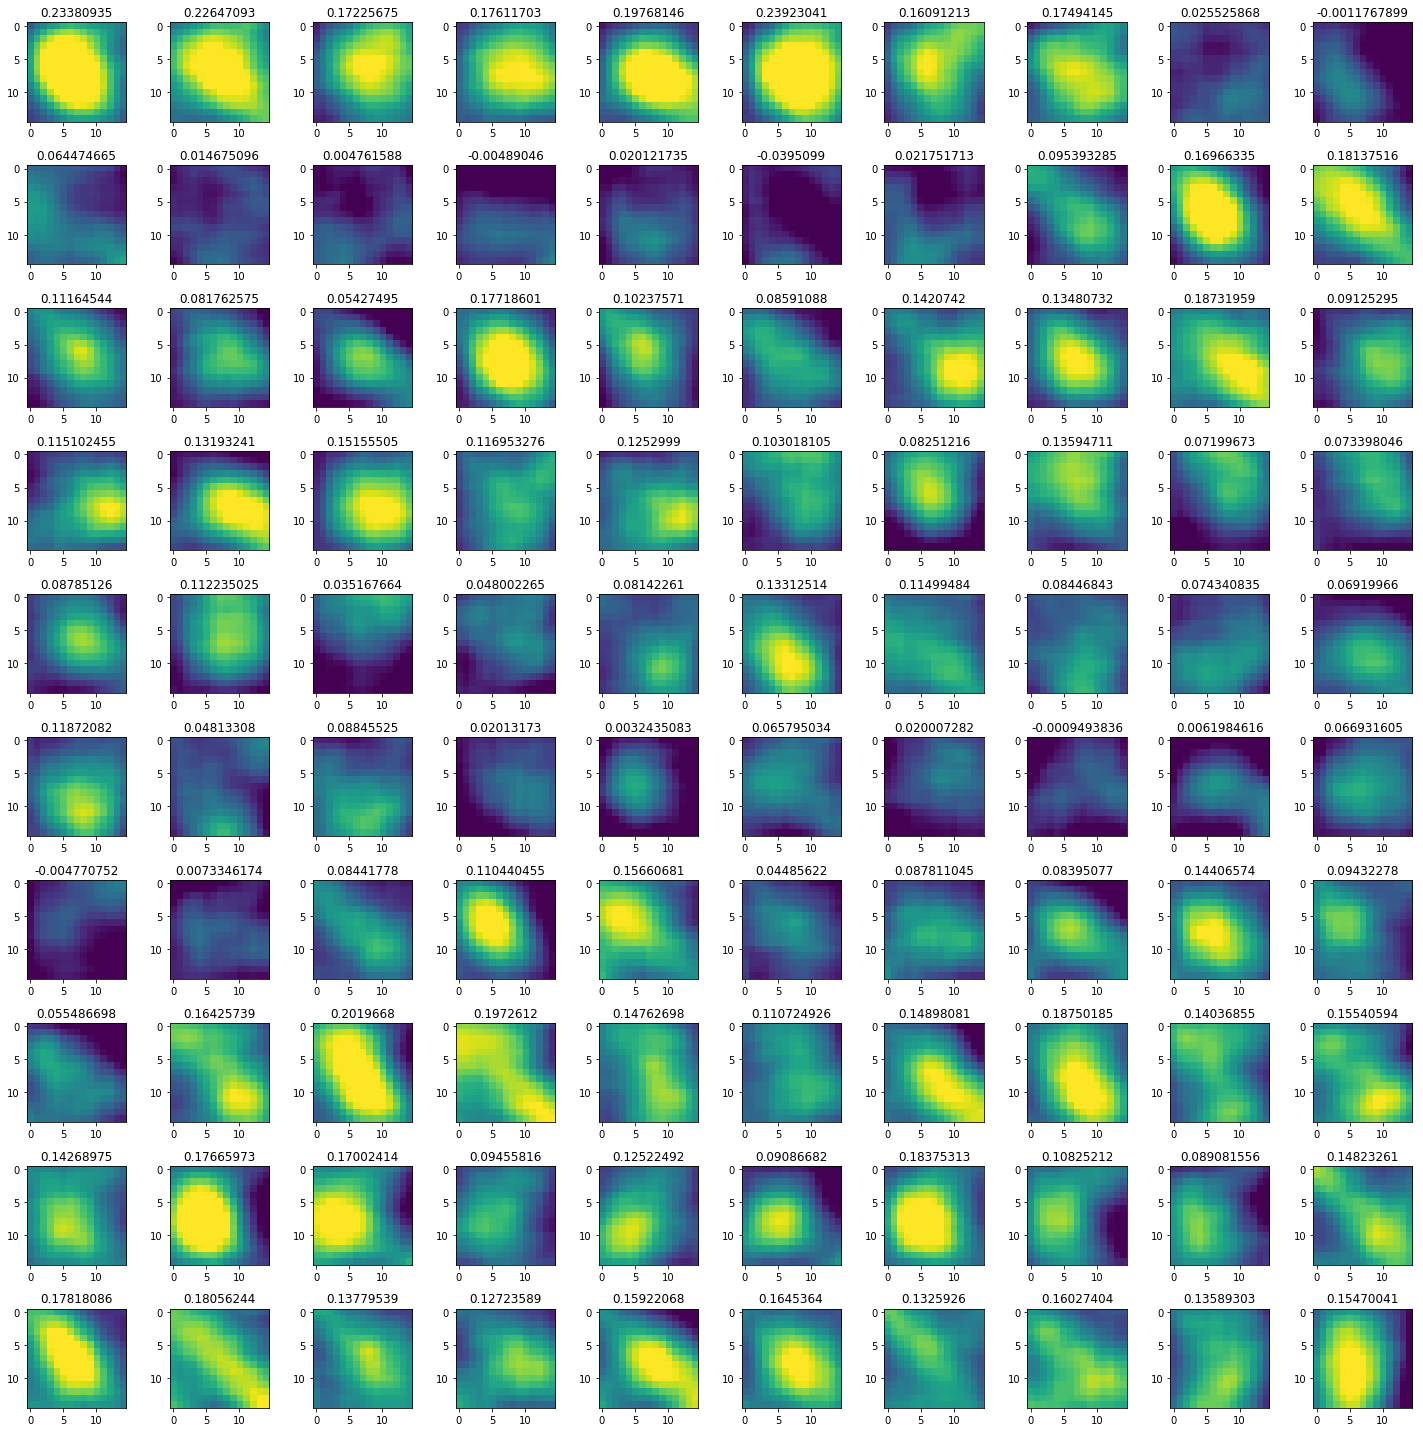

In [54]:
w = 7

figure(figsize(20,20))
for i in range(10):
    for j in range(10):
        subplot(10,10,10*i+j+1)
        #imshow(samples21[-1,3*i+j,:].reshape(360,360))
        #w = 2
        #imshow(samples01[-1,3*i+j,:].reshape(360,360)[x-w:x+w, y-w:y+w], vmin=vmin, vmax=vmax)
        #imshow(samples148[-1,i+j,:].reshape(360,360)[x-w:x+w, y-w:y+w], vmin=vmin, vmax=vmax)
        #imshow(img[10*i+j+1,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
        #imshow(img[10*i+j+1,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)
        stamp = convolutions[10*i+j+1,:].reshape(360,360)[x-w:x+w+1, y-w:y+w+1]
        imshow(stamp, vmin=vmin, vmax=vmax)
        title(np.mean(stamp))
        #colorbar()
plt.tight_layout()

Text(0.5,1,'central value')

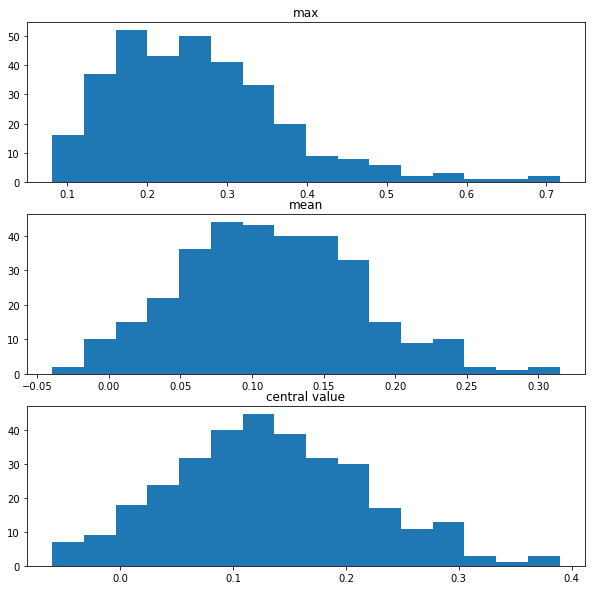

In [55]:
max_values = np.zeros(img.shape[0])
mean_values = np.zeros(img.shape[0])
central_values = np.zeros(img.shape[0])


figure(figsize(10,10))
plt.title('matched filter mean')
for k in range(len(convolutions)):
    stamp = convolutions[k,...][x-w:x+w+1, y-w:y+w+1]
    max_values[k] = np.max(stamp)
    mean_values[k] = np.mean(stamp)
    central_values[k] = stamp[w//2:w//2+1, w//2:w//2+1]

subplot(311)
plt.hist(max_values, bins=16)
title('max')
subplot(312)
plt.hist(mean_values, bins=16)
title('mean')
subplot(313)
plt.hist(central_values, bins=16)
title('central value')

In [56]:
convolutions.shape

(324, 360, 360)

In [57]:
picks = np.zeros((6, img.shape[0]))

for k in range(len(img)):
    starlet_decomp = starlet2d(image=img[k,...], nscales=5)
    for i in range(len(starlet_decomp)):
        stamp = starlet_decomp[i][x-w:x+w+1, y-w:y+w+1]
        pick = np.max(stamp)
        #pick = np.max(img[k,...][x-w:x+w, y-w:y+w])
        picks[i,k] = pick

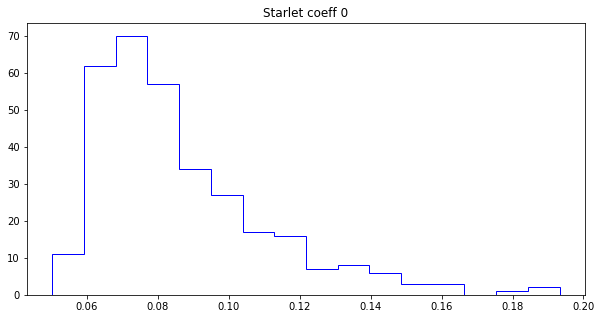

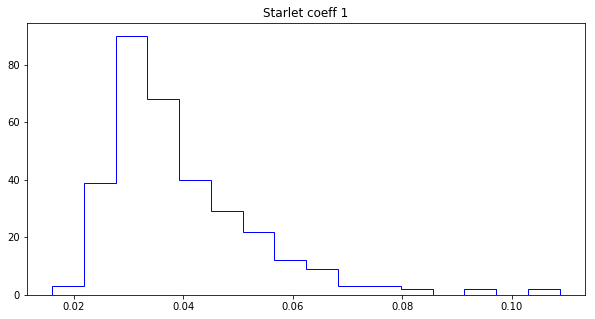

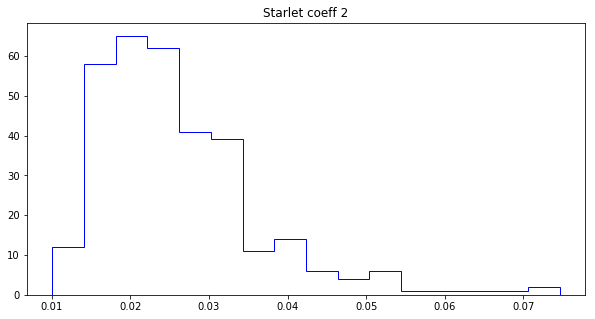

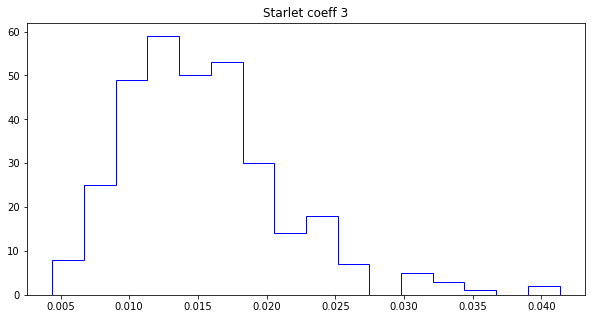

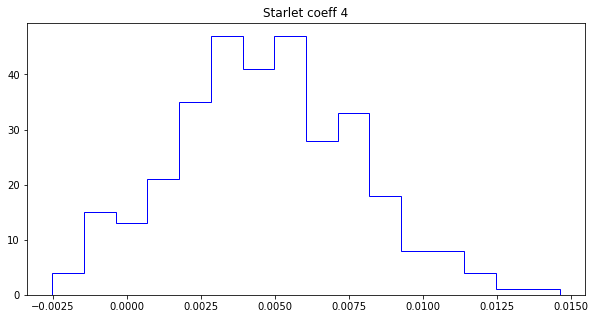

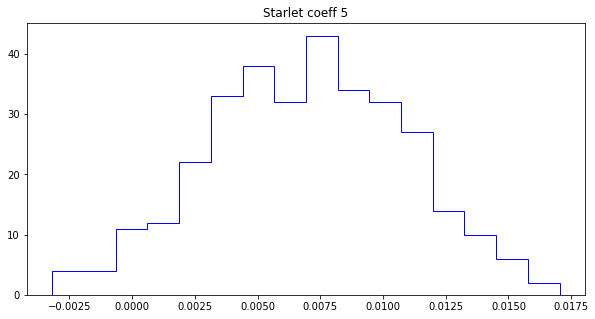

In [58]:
for i in range(len(starlet_decomp)):
    figure(i+1, figsize(10,5))
    #subplot(1, len(starlet_decomp), i+1)
    title('Starlet coeff {}'.format(i))
    kwargs = dict(histtype='stepfilled', alpha=1, density=False, bins=16, color='white')
    plt.hist(picks[i,:].flatten(), ec='blue',  label=r'$\sigma=$.07', **kwargs)

In [59]:
#imshow(s148[0,...] * ke_stamp[0,...])